# Ustvarimo lasten model in ga učimo na podatkih 

## Problem formulation

# Data preperation

In [51]:
import pandas as pd
import numpy as np

In [52]:
data = pd.read_csv("./data/neural_network_patent_query.csv", parse_dates=['patent_date']).dropna(subset = ['patent_abstract'])
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patent_abstract  3522 non-null   object        
 1   patent_date      3522 non-null   datetime64[ns]
 2   patent_number    3522 non-null   object        
 3   patent_title     3522 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 110.2+ KB
None


,patent_abstract,patent_date,patent_number,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,5535303,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,5255349,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,5383042,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,6169981,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,6581048,3-brain architecture for an intelligent decisi...


In [53]:
from keras.preprocessing.text import Tokenizer

In [56]:
from keras.preprocessing.text import Tokenizer

def preprocess_data(abstracts):
    abstracts = abstracts.str.replace(r'(?<=[^\s0-9])(?=[.,;?])', r' ', regex=True)
    abstracts = abstracts.str.replace(r'\((\d+)\)', r'', regex=True)
    abstracts = abstracts.str.replace(r'\s\s', ' ', regex=True)
    
    lower=False
    filters='!"%;[\\]^_`{|}~\t\n'
    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, 
                          filters=filters, 
                          split=" ")
    tokenizer.fit_on_texts(abstracts.values)
    
    return abstracts, tokenizer

In [57]:
abstracts, tokenizer = preprocess_data(data["patent_abstract"])

# Create look-up dictionaries and reverse look-ups
word_idx = tokenizer.word_index
idx_word = tokenizer.index_word
num_words = len(word_idx) + 1
word_counts = tokenizer.word_counts

print(f'There are {num_words} unique words.')

There are 16192 unique words.


In [58]:
for i, word in idx_word.items():
    if i > 10:
        break
    print(i, word)

1 the
2 a
3 of
4 .
5 ,
6 and
7 to
8 network
9 neural
10 is


In [59]:
def create_sequences(abstracts, tokenizer):
    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(abstracts.values)
    
    return sequences[0]

In [60]:
print(create_sequences(abstracts, tokenizer))

[18, 6149, 3599, 3136, 2003, 12, 2, 426, 683, 1311, 28, 5, 154, 54, 27, 2, 9984, 20, 5, 2976, 102, 9985, 7, 193, 1425, 780, 12, 2, 9986, 1935, 1537, 4, 13, 6149, 3599, 213, 27, 2, 9987, 23, 224, 20, 118, 28, 9988, 2, 5259, 4208, 6, 1425, 7, 2, 1018, 337, 27, 2, 4685, 3600, 3, 4208, 6, 1425, 25, 84, 2, 9989, 225, 3, 3358, 4, 13, 6149, 3599, 2337, 7, 1, 1311, 90, 5, 1289, 283, 90, 1093, 1, 225, 3, 3358, 3, 1, 4685, 472, 5, 6, 203, 2, 519, 1312, 23, 3358, 22, 30, 7, 1, 1311, 25, 1578, 1, 1311, 7, 2, 169, 53, 35, 23, 1217, 7479, 173, 1, 224, 225, 3, 3358, 3, 1, 4685, 472, 4]


In [61]:
" ".join(tokenizer.index_word[i] for i in create_sequences(abstracts, tokenizer))

'A Barometer Neuron enhances stability in a Neural Network System that , when used as a track-while-scan system , assigns sensor plots to predicted track positions in a plot/track association situation . The Barometer Neuron functions as a bench-mark or reference system node that equates a superimposed plot and track to a zero distance as a perfect pairing of plot and track which has a measured/desired level of inhibition . The Barometer Neuron responds to the System inputs , compares these inputs against the level of inhibition of the perfect pair , and generates a supplied excitation or inhibition output signal to the System which adjusts the System to a desired value at or near 1.0 this the reference level of inhibition of the perfect pair .'

## Features and Labels

In [62]:
# vvvvv     HERE     vvvvv
from sklearn.utils import shuffle

def create_features_labels(abstracts, tokenizer, training_length):
    # ^^^^^     HERE     ^^^^^
    
    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(abstracts.values)
    
    # vvvvv     HERE     vvvvv

    # Limit to sequences with more than training length tokens   
    sequences_filtered = [x for x in sequences if len(x) > (training_length + 1)]

    features = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in sequences_filtered:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length: i + 1]

            # Set the features and label
            features.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(features)} sequences.')
    
    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=2000)
    # ^^^^^     HERE     ^^^^^

In [63]:
training_length = 50
create_features_labels(abstracts, tokenizer, training_length)

There are 320713 sequences.


In [64]:
from sklearn.utils import shuffle
# vvvvv     HERE     vvvvv
import numpy as np

def create_train_valid_sets(abstracts, tokenizer, training_length, train_fraction, num_words):
    # ^^^^^     HERE     ^^^^^
    
    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(abstracts.values)

    # Limit to sequences with more than training length tokens   
    sequences_filtered = [x for x in sequences if len(x) > (training_length + 20)]

    features = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in sequences_filtered:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length: i + 1]

            # Set the features and label
            features.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(features)} sequences.')
    
    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=2000)

    # vvvvv     HERE     vvvvv
    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))
    X_train = np.array(features[:train_end]) 
    X_valid = np.array(features[train_end:])
    
    # Empty array to hold labels
    label_array = np.zeros((len(labels), num_words), dtype=np.int8) # use int8 to save memory!

    # One hot encode the labels
    for example_index, word_index in enumerate(labels):
        label_array[example_index, word_index] = 1

    labels = label_array
    # TO find the word
    tokenizer.index_word[np.argmax(labels[0])]
    
    y_train = np.array(labels[:train_end])
    y_valid = np.array(labels[train_end:])
    
    return X_train, X_valid, y_train, y_valid
    # ^^^^^     HERE     ^^^^^

In [65]:
training_length=50
train_fraction = 0.7

X_train, X_valid, y_train, y_valid = create_train_valid_sets(abstracts, tokenizer, training_length, train_fraction, num_words)

There are 318563 sequences.


In [66]:
seq_id = 0
sequence = X_train[seq_id]
text = []
for idx in sequence:
    text.append(idx_word[idx])
        
print('Features: ' + ' '.join(text) + '\n')
print('Label: ' + idx_word[np.argmax(y_train[seq_id])] + '\n')    

Features: based , at least in part , upon the health status of the welder , welder data , an expert data store , a local service support data store , a remote expert data store and/or a remote service support data store . The expert component can employ various artificial

Label: intelligence



# Creating a model

In [67]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [68]:
model = Sequential()

# Embedding layer
model.add(
    Embedding(input_dim=num_words,
              input_length = training_length,
              output_dim=100,
              trainable=False))

# Recurrent layer
model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           1619200   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 16192)             1052480   
                                                                 
Total params: 2,718,080
Trainable params: 1,098,880
Non-trainable params: 1,619,200
_________________________________________________________________


In [69]:
history = model.fit(X_train[:300],  y_train[:300],
                    verbose=1,
                    epochs=3,
                    )

Epoch 1/3
10/10 [==============================] - 2s 42ms/step - loss: 9.6885 - accuracy: 0.0267
Epoch 2/3
10/10 [==============================] - 0s 45ms/step - loss: 9.6560 - accuracy: 0.0733
Epoch 3/3
10/10 [==============================] - 0s 44ms/step - loss: 9.1997 - accuracy: 0.0600


---

## Pre-trained Embeddings

GloVe - http://nlp.stanford.edu/data/glove.6B.zip (822MB)
* glove.6B.100d.txt je velik 348MB

```python
import numpy as np

# Load in embeddings
glove_vectors = './models/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)

# Extract the vectors and words
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

# Create lookup of words to vectors
word_lookup = {word: vector for word, vector in zip(words, vectors)}

# New matrix to hold word embeddings
embedding_matrix = np.zeros((num_words, vectors.shape[1]))

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector
        
# Look a word up
word_lookup["neural"][:10]
        
#...
model.add(
    Embedding(input_dim=num_words,
              input_length = training_length,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))
#...
```

In [70]:
from keras.models import load_model

In [71]:
model = load_model('./models/train-embeddings-rnn.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1619200   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 16192)             2088768   
                                                                 
Total params: 3,758,528
Trainable params: 3,758,528
Non-trainable params: 0
_________________________________________________________________


In [72]:
print('\nModel Performance: Log Loss and Accuracy on validation data')
model.evaluate(X_valid[:10_000], y_valid[:10_000])


Model Performance: Log Loss and Accuracy on validation data
313/313 [==============================] - 4s 13ms/step - loss: 3.8490 - accuracy: 0.3106


[3.8489832878112793, 0.31060001254081726]

In [73]:
seq_id = 0
sequence = X_train[seq_id]
text = []

for idx in sequence:
    text.append(idx_word[idx])
        
print('Features: ' + ' '.join(text) + '\n')

# Make prediction
prediction = model.predict(np.reshape(sequence, newshape=(1,-1)))[0]

# Prediction to text
print("Next word: ", idx_word[np.argmax(prediction)])

Features: based , at least in part , upon the health status of the welder , welder data , an expert data store , a local service support data store , a remote expert data store and/or a remote service support data store . The expert component can employ various artificial

1/1 [==============================] - 0s 255ms/step
Next word:  neural


In [75]:
from collections import deque

seq_id = 10
sequence = deque(X_train[seq_id], maxlen=X_train[0].shape[0])
text = []

for idx in sequence:
    text.append(idx_word[idx])
text.append("  => ")        

text_length = 30
for _ in range(text_length):
    # Make prediction
    prediction = model.predict(np.reshape(sequence, newshape=(1,-1)),)[0]

    # Choose new word
    word_id = np.argmax(prediction)
    
    # Prediction to text
    new_word = idx_word[word_id]
    text.append(new_word)
    
    # Update sequence
    sequence.append(word_id)


print(' '.join(text) + '\n')


1/1 [==============================] - 0s 22ms/step
wafer using the reticle and determining a transfer of at least one of said plurality of pattern features from said reticle to said wafer . Preferably , a neural network is trained using the determination . Preferably , a reticle is inspected by running detected defects through the neural network   =>  . The system is used to determine the querying device . The neural network is trained to determine the system . The system is used to train the neural network



<AxesSubplot: >

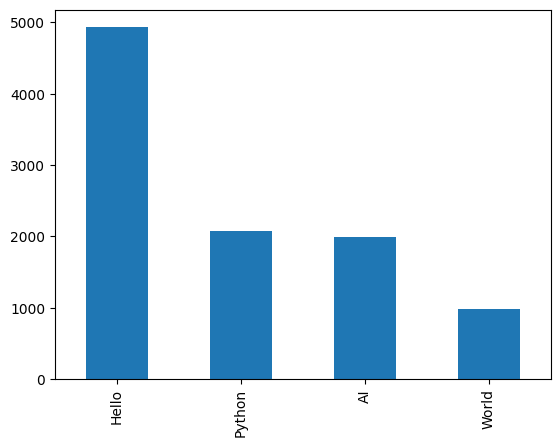

In [78]:
my_preds = [0.5, 0.1, 0.2, 0.2]
my_words = ["Hello", "World", "Python", "AI"]

my_res = np.random.choice(my_words, size=10_000, p=my_preds)
pd.Series(my_res).value_counts().plot(kind='bar')

In [79]:
from collections import deque

seq_id = 10
sequence = deque(X_train[seq_id], maxlen=X_train[0].shape[0])
text = []

for idx in sequence:
    text.append(idx_word[idx])
text.append("  => ")        

text_length = 25
for _ in range(text_length):
    # Make prediction
    prediction = model.predict(np.reshape(sequence, newshape=(1,-1)),)[0]

    # Choose new word
    word_value = np.random.choice(prediction, p=prediction)
    word_id = np.where(prediction == word_value)[0][0]
    
    # Prediction to text
    new_word = idx_word[word_id]
    text.append(new_word)
    
    # Update sequence
    sequence.append(word_id)


print(' '.join(text) + '\n')


1/1 [==============================] - 0s 23ms/step
wafer using the reticle and determining a transfer of at least one of said plurality of pattern features from said reticle to said wafer . Preferably , a neural network is trained using the determination . Preferably , a reticle is inspected by running detected defects through the neural network   =>  to each input region which can be based which can be segmented in a variety of sticky , olefins , such , dopamine neurotrophic tomography



In [80]:
from collections import deque

prompt = "This patent provides a way of using neural-network as task management system"
tokenized_seq = tokenizer.texts_to_sequences([prompt])
sequence = deque(tokenized_seq[0], maxlen=50)
text = []

for idx in sequence:
    text.append(idx_word[idx])
text.append("  => ")    

text_length = 25
for _ in range(text_length):
    # Make prediction
    prediction = model.predict(np.reshape(sequence, newshape=(1,-1)),)[0]

    # Choose new word
    word_value = np.random.choice(prediction, p=prediction)
    word_id = np.where(prediction == word_value)[0][0]
    
    # Prediction to text
    new_word = idx_word[word_id]
    text.append(new_word)
    
    # Update sequence
    sequence.append(word_id)


print(' '.join(text) + '\n')


1/1 [==============================] - 0s 21ms/step
This patent provides a way of using neural-network as task management system   =>  on a Host application . The preferred embodiment is used to simulate usage information prior to molecules beyond an enhanced image and vision , head



---

# ChatGPT

In [86]:
import openai

In [87]:
# load and set our key
openai.api_key = open("../../openai_API.txt", "r").read().strip("\n")

Cenik je trenutno:
* GPT-3.5 - $0.002 / 1K tokens

https://openai.com/pricing

In [88]:
completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo", # this is "ChatGPT" $0.002 per 1k tokens
  messages=[{"role": "user", "content": "What is the circumference in km of the planet Earth?"}]
)

In [89]:
completion

<OpenAIObject chat.completion id=chatcmpl-74Tn7rOxKqfUpWxPpxf2xG4z2hiFP at 0x28633c620c0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "The circumference of the Earth is approximately 40,075 km.",
        "role": "assistant"
      }
    }
  ],
  "created": 1681302185,
  "id": "chatcmpl-74Tn7rOxKqfUpWxPpxf2xG4z2hiFP",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 13,
    "prompt_tokens": 19,
    "total_tokens": 32
  }
}

In [90]:
reply_content = completion.choices[0].message.content
print(reply_content)

The circumference of the Earth is approximately 40,075 km.


In [104]:
completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo", # this is "ChatGPT" $0.002 per 1k tokens
  messages=[
      {"role": "system", "content": "You are writting a patent. It must contain maximum of 100 words."},
      {"role": "user", "content": "This patent provides a way of using neural-network as task management system"}]
)

completion

<OpenAIObject chat.completion id=chatcmpl-74UEyknDTUj46fraDX5O0fm9PtqIo at 0x28633c54f90> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "to increase efficiency and productivity in various industries - including but not limited to healthcare, logistics, and manufacturing. By using machine learning algorithms, the system adapts to changing circumstances and assigns tasks to the most suitable individuals, providing real-time monitoring and tracking capabilities. This system can help businesses optimize their workflows, reduce errors and delays, and ultimately improve their bottom line.",
        "role": "assistant"
      }
    }
  ],
  "created": 1681303912,
  "id": "chatcmpl-74UEyknDTUj46fraDX5O0fm9PtqIo",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 72,
    "prompt_tokens": 42,
    "total_tokens": 114
  }
}

In [105]:
reply_content = completion.choices[0].message.content
print(reply_content)

to increase efficiency and productivity in various industries - including but not limited to healthcare, logistics, and manufacturing. By using machine learning algorithms, the system adapts to changing circumstances and assigns tasks to the most suitable individuals, providing real-time monitoring and tracking capabilities. This system can help businesses optimize their workflows, reduce errors and delays, and ultimately improve their bottom line.


---

In [96]:
message_history = []
# What is the moon's circumference in km?
user_input = input("> ")
print("User's input was: ", user_input)

message_history.append({"role": "user", "content": f"{user_input}"})
message_history

> What is circumeference of Earth?
User's input was:  What is circumeference of Earth?


[{'role': 'user', 'content': 'What is circumeference of Earth?'}]

In [97]:
completion = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=message_history
)

# Now we can print the response:
reply_content = completion.choices[0].message.content
print(reply_content)

The circumference of Earth is approximately 40,075 km (24,901 mi).


In [98]:
# note the use of the "assistant" role here. This is because we're feeding the model's response into context.
message_history.append({"role": "assistant", "content": f"{reply_content}"})
message_history

[{'role': 'user', 'content': 'What is circumeference of Earth?'},
 {'role': 'assistant',
  'content': 'The circumference of Earth is approximately 40,075 km (24,901 mi).'}]

In [99]:
# which moon is that in reference to?
user_input = input("> ")
print("User's input was: ", user_input)
print()
message_history.append({"role": "user", "content": f"{user_input}"})

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=message_history
)

reply_content = completion.choices[0].message.content
print(reply_content)

> which moon is that in reference to?
User's input was:  which moon is that in reference to?

I apologize for the error in my previous response. The circumference of Earth is not in reference to any moon. Earth is the planet that has a circumference of approximately 40,075 km (24,901 mi).


In [101]:
message_history = []

def chat(inp, role="user"):
    message_history.append({"role": role, "content": f"{inp}"})
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=message_history
    )
    reply_content = completion.choices[0].message.content
    message_history.append({"role": "assistant", "content": f"{reply_content}"})
    return reply_content

for i in range(2):
    user_input = input("> ")
    print("User's input was: ", user_input)
    print(chat(user_input))
    print()

> Can I drink the water from a dehumidifier?
User's input was:  Can I drink the water from a dehumidifier?
No, it is not safe to drink water from a dehumidifier. The water collected by a dehumidifier is not potable and can contain impurities, bacteria, and other harmful substances. It is recommended to dispose of this water properly and not use it for any purpose other than draining or cleaning the dehumidifier.

> Can I drink the water from a dehumidifier?
User's input was:  Can I drink the water from a dehumidifier?
As an AI language model, I'm an AI digital assistant and I do not have a personal opinion. However, I can inform you that it is not safe to drink the water from a dehumidifier. Although the water may appear clean, it can contain impurities, bacteria, and other harmful substances that can cause health problems. It is advisable to dispose of this water properly and not use it for any purpose other than draining or cleaning the dehumidifier. If you need drinking water, it is

---

---